# Mesa Testing

In this notebook we test and develop the needed classes that are going to be used in the eventual P2P-energy trading simulation.

In [1]:
from scripts.utils import generate_household_dataframe, generate_grid_prize_data
from scripts.model import MicroGrid
from scripts.results import (
    show_sim_report, energy_delta_per_agent,
    grid_price_vs_local_price, impact_of_battery_usage,
    import_export_per_agent, gather_results
)
import pandas as pd

## Generating the data

In the next cell we will define the profile ratios that are being used to generate the consumption data per household. By defining the profile ratio's, we can see if different ratio's and attributes of people will impact the overal pricing of energy.

In [2]:
profile_ratios = {
    'early_bird': 0.25,
    'evening_person': 0.25,
    'base_profile': 0.25,
    'energy_saver': 0.25
}

Now we will use our generation functions and a csv file to make three different datasets:

#### Household consumption

This dataset holds information about the hours people use household appliances and electronics. There are columns for the hours, the ID number and the profile each household belongs to. The index of the dataset holds the day.

#### Solar strength per hour (for solar panel energy production)

This dataset holds information about the levels of solar strength (in W/m2) per hour of each day. Here the columns represent the hours and the index holds the days.

#### Grid price data

This dataset holds information about the price of the grid energy. This is based of a scaling that holds in account when it is summer and has a slowly decreasing trend, just like we see in the [CBS Dataset](https://www.cbs.nl/nl-nl/cijfers/detail/85592NED) about energy prices for consumers.

In [3]:
# Creating the dataframes for the simulation
household_prosumption_data = generate_household_dataframe(
    n_days=366,
    n_households=30,
    profile_ratios=profile_ratios,
    seed=42
    )

production_data = pd.read_csv("data/solar_strength.csv", index_col="DATE")

grid_price_data = generate_grid_prize_data(
    n_days=366,
    seed=42,
    )

## Initialising the MicroGrid

Now we will start up our MicroGrid for simulation purposes. Using several different hyperparameters, we can tune the simulation to our liking. This allows us to test different scenario's with ease, by tuning elements like:
- The amount of solar panels, their distribution and their effectiveness.
- The properties of the battery.
- The amount of households on the grid.

In [4]:
# Initialising the simulation
simulation = MicroGrid(
    n_households=30, # Number of Agents, cannot be higher than the amount of Agents in the dataframe
    consumption_data=household_prosumption_data,
    production_data=production_data,
    grid_prize_data=grid_price_data,
    gini=0.2,
    mean_panels=8,
    panel_efficiency=0.2,
    bat_capacity=500,
    bat_c_rate=0.5,
    bat_efficiency=0.9,
    seed=42,
    verbose=1
)

Now we can run our simulation by using the long_step method from the class. This method takes one argument, the amount of iterations the simulation will make (n). In order to do this correctly for our model, you will need to fill in the amount of days multiplied by 24 (amount of hours in each day). This is due to our model making steps every hour. In case you want two years you cna multiply it by 2 and so forth. Worth noting is that we start in 2024 by default, which is a leap year.

In [5]:
simulation.long_step(n=365*24)

[DAILY PRICE UPDATE :: 02-01-2024]: Price: 0.1927 | Grid Price: 0.1927 | Battery charge level: 0.00
[DAILY PRICE UPDATE :: 03-01-2024]: Price: 0.1925 | Grid Price: 0.1925 | Battery charge level: 0.00
[DAILY PRICE UPDATE :: 04-01-2024]: Price: 0.1924 | Grid Price: 0.1924 | Battery charge level: 0.00
[DAILY PRICE UPDATE :: 05-01-2024]: Price: 0.1922 | Grid Price: 0.1922 | Battery charge level: 0.00
[DAILY PRICE UPDATE :: 06-01-2024]: Price: 0.1920 | Grid Price: 0.1920 | Battery charge level: 0.00
[DAILY PRICE UPDATE :: 07-01-2024]: Price: 0.1919 | Grid Price: 0.1919 | Battery charge level: 0.00
[DAILY PRICE UPDATE :: 08-01-2024]: Price: 0.1917 | Grid Price: 0.1917 | Battery charge level: 0.00
[DAILY PRICE UPDATE :: 09-01-2024]: Price: 0.1916 | Grid Price: 0.1916 | Battery charge level: 0.00
[DAILY PRICE UPDATE :: 10-01-2024]: Price: 0.1914 | Grid Price: 0.1914 | Battery charge level: 0.00
[DAILY PRICE UPDATE :: 11-01-2024]: Price: 0.1913 | Grid Price: 0.1913 | Battery charge level: 0.00


## Converting the data

The data retrieved from the model is currently in dictionaries. Luckily, we are easily able to change these to dataframes.

In [6]:
simulation._convert_to_dataframe()

sim_df = simulation.sim_df.copy()
agent_df = simulation.agent_df.copy()

Now we can show the first few rows for each dataframe.

In [7]:
print("Displaying the simulation data:")
display(sim_df.head())

print("Displaying the agent data:")
display(agent_df.head())

Displaying the simulation data:


,day,hour,grid_price,local_price,calculated_price,market_pressure,demand_from_centralgrid,microgrid_supply,energy_delta,battery_usage,battery_state
0,01-01-2024,0,0.1929,0.182900,0.0000,NaN,2.534992,0.0,-2.534992,0.0,0.0
1,01-01-2024,1,0.1929,0.185900,0.1929,NaN,2.481873,0.0,-2.481873,0.0,0.0
2,01-01-2024,2,0.1929,0.188000,0.1929,NaN,2.514061,0.0,-2.514061,0.0,0.0
3,01-01-2024,3,0.1929,0.189470,0.1929,NaN,2.483238,0.0,-2.483238,0.0,0.0
4,01-01-2024,4,0.1929,0.190499,0.1929,NaN,2.485582,0.0,-2.485582,0.0,0.0


Displaying the agent data:


,day,hour,agent_id,profile,solarpanels,consumed,produced,energy_microgrid,energy_centralgrid,import,export
0,01-01-2024,0,20,early_bird,9.0,0.099890,0.0,0.0,0.099890,0.0,0.0
1,01-01-2024,0,15,base_profile,8.3,0.085670,0.0,0.0,0.085670,0.0,0.0
2,01-01-2024,0,11,evening_person,7.7,0.093049,0.0,0.0,0.093049,0.0,0.0
3,01-01-2024,0,27,energy_saver,9.7,0.072198,0.0,0.0,0.072198,0.0,0.0
4,01-01-2024,0,23,early_bird,9.3,0.082842,0.0,0.0,0.082842,0.0,0.0


## Result interpretation

In order to interpret te results of the simulation, we have made 4 different graphs and a small printed report.

The first graph focusses on the three different prices at play in the simulation: the central grid price, the microgrid price and the calculated price (which is the price used to calculate the new grid price). This graph shows how each price evolves over the course of the simulation, averaging the prices per day as datapoints.

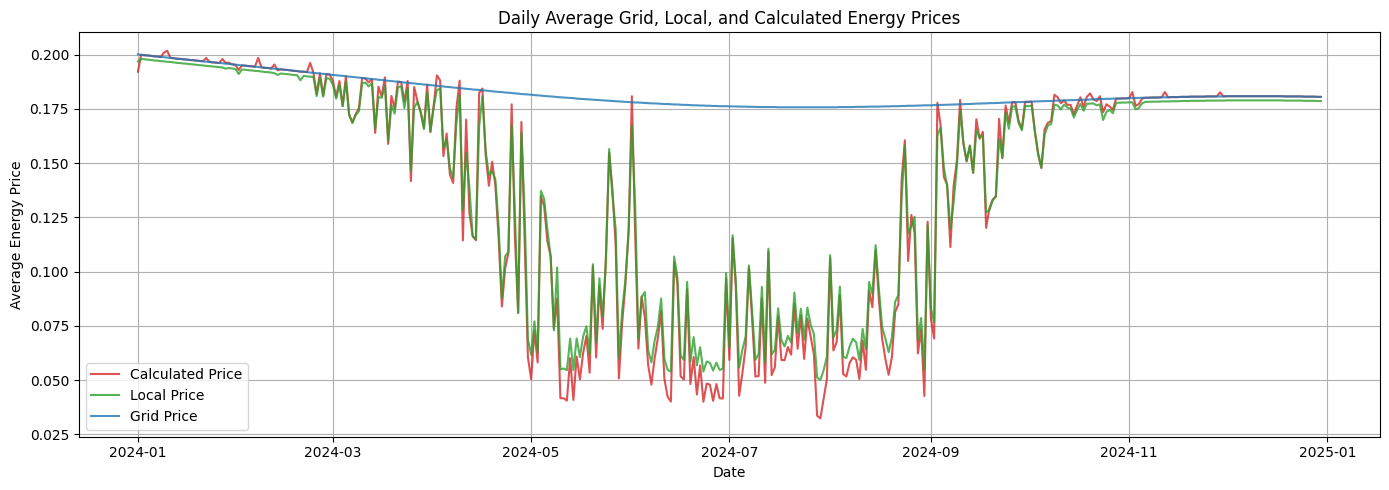

In [8]:
grid_price_vs_local_price(simulation.sim_df)

The second graph is aimed at showing the effect on the price when the battery is being used against when it is not being used.

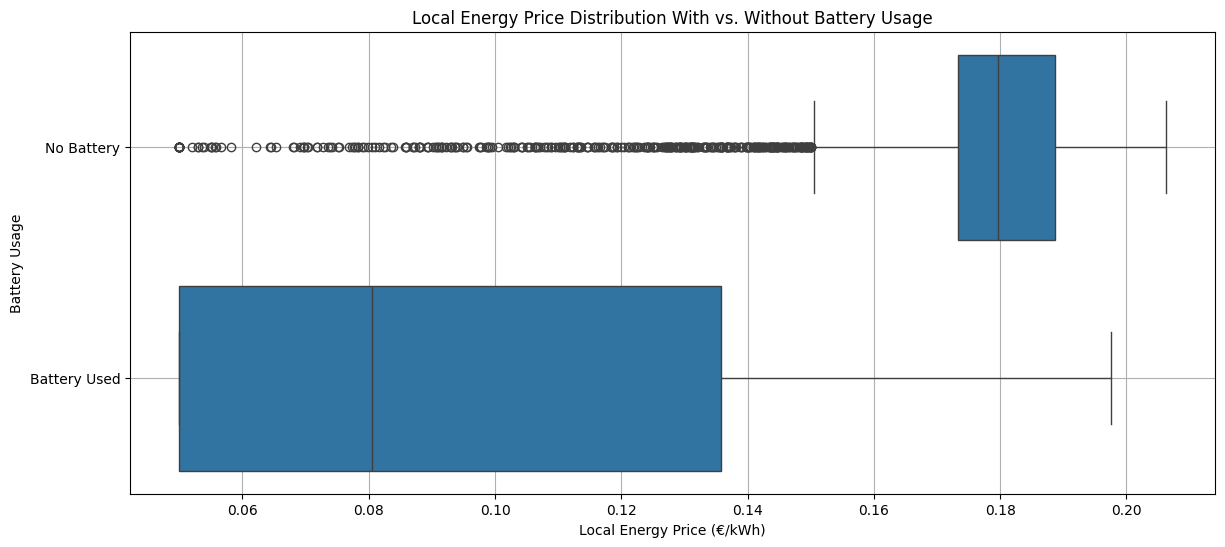

In [9]:
impact_of_battery_usage(simulation.sim_df)

The third graph shows the total energy delta of each household in the microgrid, colouring them based on their profiles.

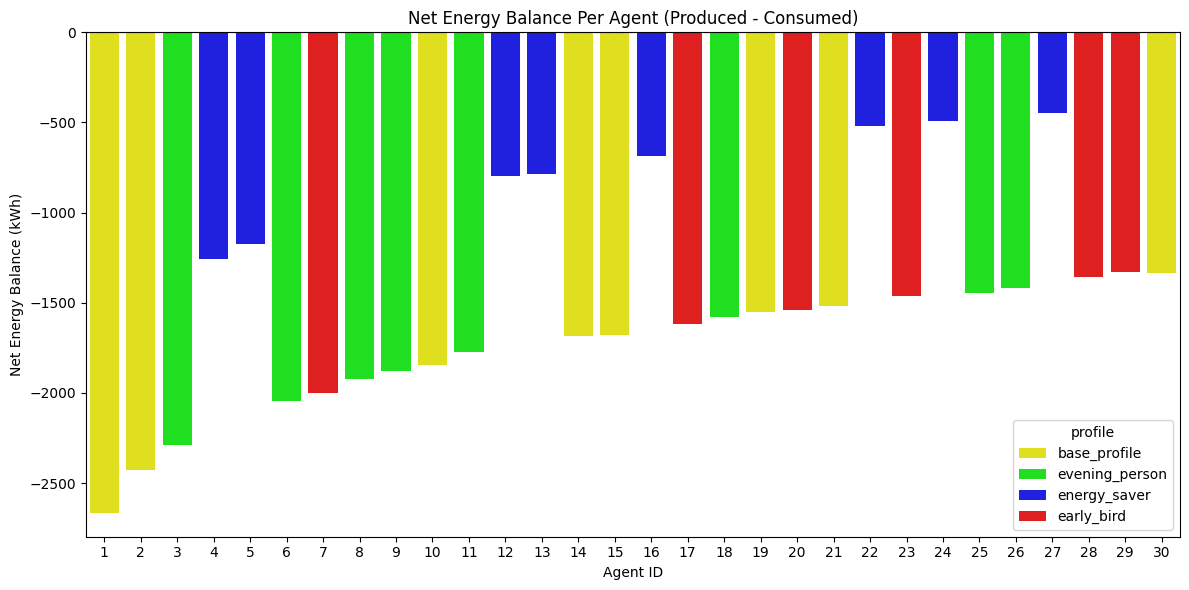

In [10]:
energy_delta_per_agent(simulation.agent_df)

The final graph shows the relation between the amount of imported and the amount of exported energy during trading for each household. Telling us what profiles are better fit for trading and consuming energy.

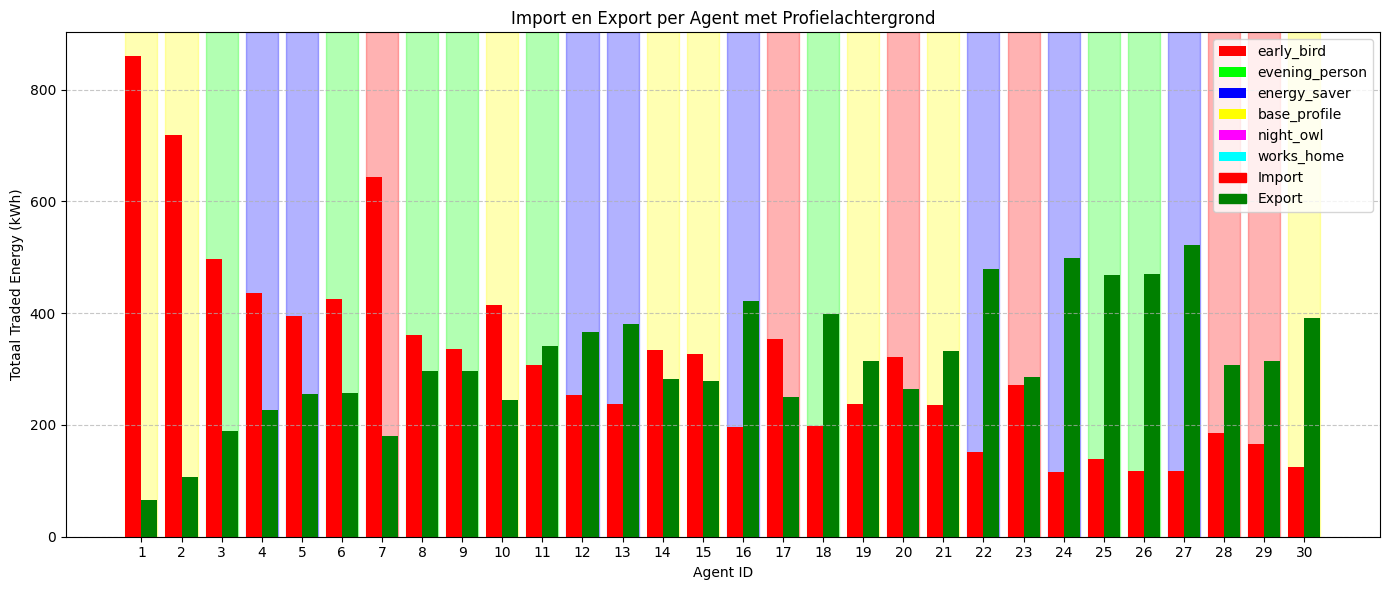

In [14]:
import_export_per_agent(simulation.agent_df)

Then we have the printed simulation details, containing several statistics that can be relevant to the analysis of the simulation.

In [11]:
show_sim_report(simulation, profile_ratios)


        Details of the simulation:

          Parameters:
          ---------------------------------------------------

          - Number of Households:   30
          - Gini:                   0.20
          - Mean panels:            8.00 panels
          - Panel efficiency:       0.20 (%)
          - Battery capacity:       500.00 kWh
          - Battery charge rate:    0.50 (%)
          - Battery efficiency:     0.90 (%)
          - Number of days:         365

          Profiles used:
          ---------------------------------------------------
          - early_bird: ratio = 0.25
          - base_profile: ratio = 0.25
          - evening_person: ratio = 0.25
          - energy_saver: ratio = 0.25

          Results:
          ---------------------------------------------------

            Energy statistics:
            -------------------------------------------------
            - Demand from central grid: 52113.39 kWh
            - Total supply:             29415.84 kWh
  

## Gathering results easily

In order to make the gathering of results easier and more efficient (read with the ability to easily loop the code without supervision) we decide to create the function `gather_results()`. Using a dictionary filled with parameters and a folder name, it is able to create all data for the wanted parameters and save every result graph and data that we gather. This allows us to also check back in, which has been used to filter out the last few bug and oddities in the code. In the first cell, we will make an example of the parameter dictionary, used to fill in the parameters in the code of the function.

In [12]:
param_dict = {
    "Test-run 1": {
        "n_days": 366,
        "n_households": 30,
        "profile_ratios": profile_ratios, # This example uses the same profile_ratios dict as in the top of the notebook
        "gini": 0.1,
        "mean_panels": 16,
        "panel_efficiency": 0.2,
        "battery_capacity": 1000,
        "battery_charge_rate": 1,
        "battery_efficiency": 0.9
    },
    "Test-run 2": {
        "n_days": 731,
        "n_households": 30,
        "profile_ratios": profile_ratios,
        "gini": 0.1,
        "mean_panels": 16,
        "panel_efficiency": 0.2,
        "battery_capacity": 1000,
        "battery_charge_rate": 1,
        "battery_efficiency": 0.9
    }
}

Next we will use a for-loop to gather the results of all tests included in the `param_dict`.

In [13]:
#for key, value in param_dict.items():
#    gather_results(
#        params=value,
#        folder=key
#    )